In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiPoint
import networkx as nx
import geonetworkx as gnx
import google_conf


In [2]:
plt.style.use('seaborn-white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_31002/1576836852.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [34]:
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson", driver="GeoJSON")
pleiades_regions_merged = pleiades_regions.unary_union

In [3]:
provinces = gpd.read_file("../data/roman_province_boundaries.json")
provinces = provinces.to_crs("EPSG:4326")
len(provinces)

61

In [4]:
centroid_series = provinces.centroid

/var/folders/zg/zvg9y3rs7j527jxfq9sc2xqc0000gn/T/ipykernel_31002/1802002792.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid_series = provinces.centroid


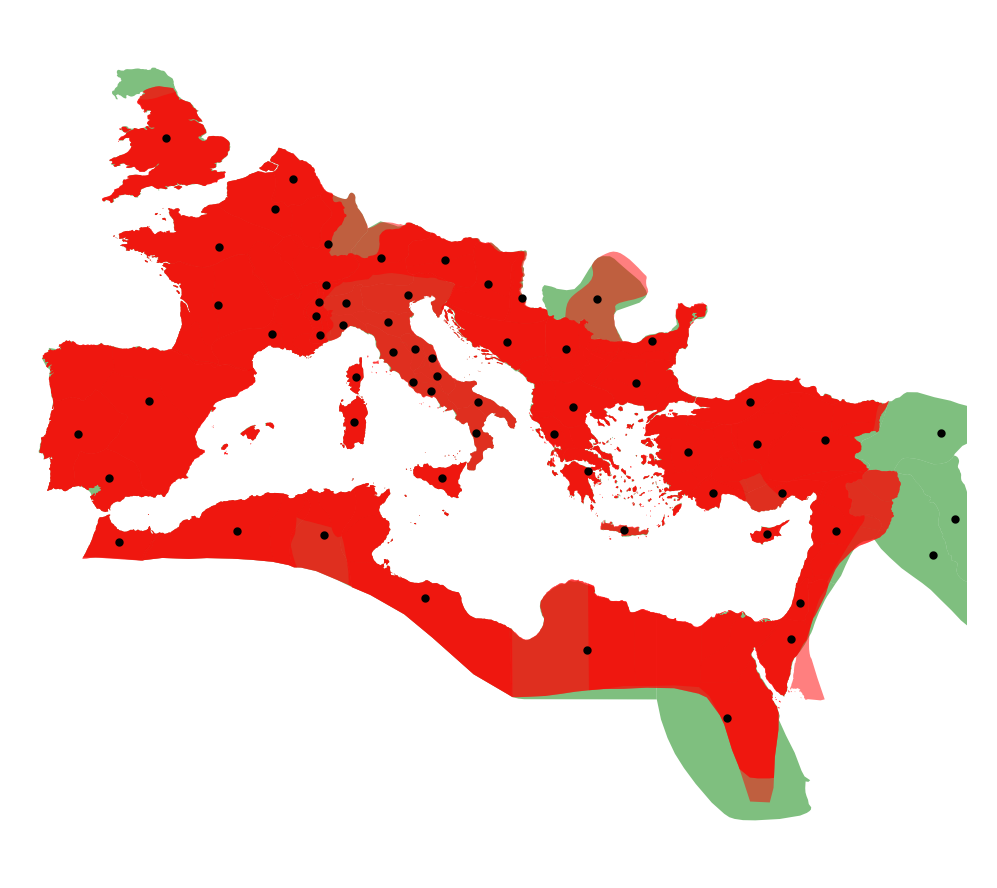

In [39]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="green", ax=ax, alpha=0.5)
pleiades_regions.plot(ax=ax, color="red", alpha=0.5)
centroid_series.plot(markersize=1, color="black", ax=ax)
ax.set_xlim(-10, 45)
ax.set_axis_off()

In [11]:
G = nx.complete_graph(len(provinces))

In [12]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60))

In [13]:
centroid_series.tolist()

In [27]:
centroid_series_pos = centroid_series.apply(lambda point: (point.x, point.y))

In [31]:
pos_dict = dict(zip(range(len(centroid_series_pos)), centroid_series_pos.tolist()))
pos_dict

{0: (22.746225971707617, 37.88324141018042),
 1: (7.350252801970795, 46.280822758228645),
 2: (6.936089574726544, 45.52158927673218),
 3: (12.575403426403991, 43.36422703611117),
 4: (13.595846804034123, 42.99114524700101),
 5: (13.890619981519587, 42.15847499734596),
 6: (13.559398412074893, 41.50852910978399),
 7: (11.302169060731936, 43.231435112935976),
 8: (8.542530064337342, 45.4675630504128),
 9: (8.35342120266437, 44.47637396205509),
 10: (11.00089303901565, 44.60337861661467),
 11: (6.8053557567748975, 44.87287797752985),
 12: (7.031725786173242, 44.00683044406708),
 13: (12.160602407503891, 45.83353827599476),
 14: (16.15187714641787, 39.61578519885989),
 15: (14.177160478040006, 37.57898845358525),
 16: (9.031052009998616, 40.08214467226826),
 17: (9.103900564176078, 42.140579725532845),
 18: (16.301758360464074, 41.003826005318835),
 19: (28.584493012615635, 38.76384474470005),
 20: (-2.021297121698538, 52.90310551804363),
 21: (24.857080449996666, 35.229967347312915),
 22:

In [28]:
gG = gnx.GeoGraph(G)

In [29]:
gG.set_nodes_coordinates(pos_dict)

In [30]:
gG.get_nodes_as_points()

{0: <shapely.geometry.point.Point at 0x2984666e0>,
 1: <shapely.geometry.point.Point at 0x298466f20>,
 2: <shapely.geometry.point.Point at 0x29830c490>,
 3: <shapely.geometry.point.Point at 0x29862f160>,
 4: <shapely.geometry.point.Point at 0x2984665c0>,
 5: <shapely.geometry.point.Point at 0x298466920>,
 6: <shapely.geometry.point.Point at 0x2984666b0>,
 7: <shapely.geometry.point.Point at 0x2984658d0>,
 8: <shapely.geometry.point.Point at 0x298466d40>,
 9: <shapely.geometry.point.Point at 0x298466e90>,
 10: <shapely.geometry.point.Point at 0x298467100>,
 11: <shapely.geometry.point.Point at 0x298465990>,
 12: <shapely.geometry.point.Point at 0x298466da0>,
 13: <shapely.geometry.point.Point at 0x2984656c0>,
 14: <shapely.geometry.point.Point at 0x298466860>,
 15: <shapely.geometry.point.Point at 0x2984657e0>,
 16: <shapely.geometry.point.Point at 0x2984665f0>,
 17: <shapely.geometry.point.Point at 0x298466530>,
 18: <shapely.geometry.point.Point at 0x298465fc0>,
 19: <shapely.geometry

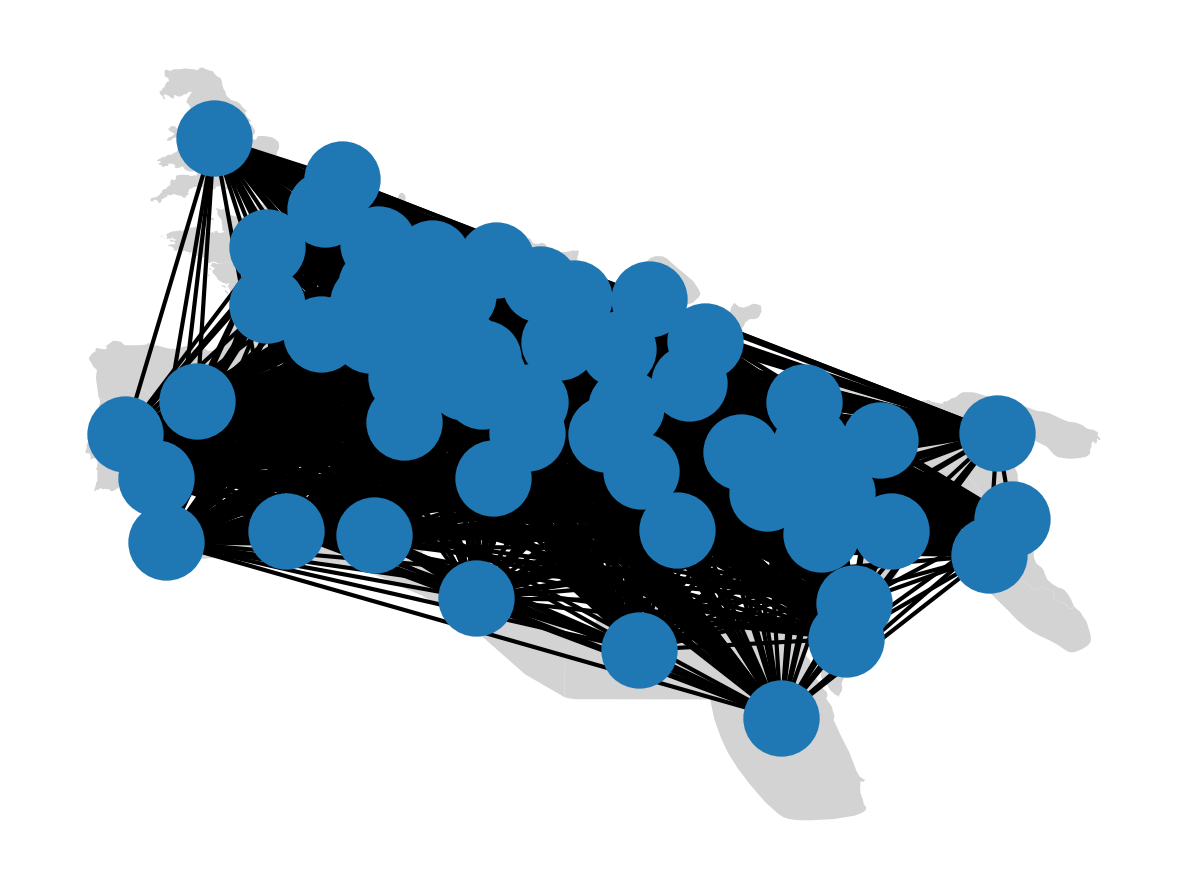

In [33]:
fig, ax = plt.subplots(figsize=(5.2, 3), dpi=300, tight_layout=True)
provinces.plot(color="lightgray", ax=ax)
nx.draw(gG, pos=pos_dict)